In [18]:
import pandas as pd
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", None)


In [27]:

import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import bootstrap


full_df = pd.read_csv("results/all_runs_latest.csv")


In [117]:
def format_data(in_df):
    df = in_df.copy()
    df = df[(df['Run ID'].str.startswith('2026012'))]

    config_map = {
        "ctx1_fog00_p4pfalse_contract_contract_for_finishing_selfish11": "Finishing Contract",
        "ctx1_fog00_p4pfalse_contract_none_selfish11": "No Contract",
        "ctx1_fog00_p4pfalse_contract_strict_selfish11": "Strict Contract",
        "ctx1_fog00_p4pfalse_contract_tile_with_judge_implementation_selfish11": "Judge Contract",
        "ctx1_fog00_p4ptrue_contract_contract_for_finishing_selfish11": "P4P Finishing Contract",
        "ctx1_fog00_p4ptrue_contract_none_selfish11": "P4P No Contract",
        "ctx1_fog00_p4ptrue_contract_strict_selfish11": "P4P Strict Contract",
        "ctx1_fog00_p4ptrue_contract_tile_with_judge_implementation_selfish11": "P4P Judge Contract"
    }
    df['Config Label'] = df['Config ID'].map(config_map)
    df['Contract Type'] = df['Contract Type'].fillna('No Contract')
    models = df["Model Pair"].str.partition("-")
    same_model = models[0] == models[2]
    df["Model"] = np.where(same_model, models[0], df["Model Pair"])
    
    # check if 0 or 1 have final leverage tile in the gir
    def _has_final_leverage_tile(grid_str: str, target: str) -> bool:
        g = ast.literal_eval(grid_str)  # safer than eval
        return (g[2][3] == target) and (g[3][2] == target)
    df["Player 0 Has Final Leverage Tile"] = df["Grid"].apply(lambda s: _has_final_leverage_tile(s, "R"))
    df["Player 1 Has Final Leverage Tile"] = df["Grid"].apply(lambda s: _has_final_leverage_tile(s, "B"))
    df["Either Player Has Final Leverage Tile"] = df["Player 0 Has Final Leverage Tile"] | df["Player 1 Has Final Leverage Tile"]

    # core metrics: both finished and accuracy
    df['both_finished'] = (df['Reached Goal Player 0'] > 0) & (df['Reached Goal Player 1'] > 0)
    df['Accuracy'] = df['Total Score'] / df['Max Possible Score']
    
    # beating baselines is core metric for NPB analysis
    # For independent it is not possbile for both to beat baseline
    # For mutual dependency , it is equivalent to both finishing
    df['R_beats_baseline'] = df['Score Player 0'] > df['Non-Cooperative Baseline Player 0']
    df['B_beats_baseline'] = df['Score Player 1'] > df['Non-Cooperative Baseline Player 1']
    df['both_beat_baseline'] = df['R_beats_baseline'] & df['B_beats_baseline']

    ## equality measures
    ## use this to look at first mover advantage for contracts, as well as if P0 can leverage its better situation in NPB
    # points_proportion_0 another core metric (i prefer it to gini b/c easier to interpret)
    df['points_proportion_0'] = df['Score Player 0'] / (df['Score Player 0'] + df['Score Player 1'])
    df['trade_volume_proportion_0'] = df['amount_received_by_0_from_trades'] / (df['amount_received_by_0_from_trades'] + df['amount_received_by_1_from_trades'])
    # note that player 1 keeping a p4p promise is equivalent to player 0 receiving a p4p payment
    df['p4p_volume_proportion_0'] = df['Total P4P Promises Kept Player 1'] / (df['Total P4P Promises Kept Player 1'] + df['Total P4P Promises Kept Player 0'])
    df['strict_contract_tile_proportion_0'] = df['num_tiles_promised_to_receive_from_contract_0'] / (df['num_tiles_promised_to_receive_from_contract_0'] + df['num_tiles_promised_to_receive_from_contract_1'])
    df['contract_for_finishing_points_proportion_0'] = df['points_for_completion_promised_to_0'] / (df['points_for_completion_promised_to_0'] + df['points_for_completion_promised_to_1'])

    ## cooperation metrics
    df['total_trade_volume'] = df['amount_received_by_0_from_trades'] + df['amount_received_by_1_from_trades']
    df['trade_acceptance_rate_0'] = df['Total Trades Accepted Player 0'] / df['Total Trades Proposed Player 1']
    df['trade_acceptance_rate_1'] = df['Total Trades Accepted Player 1'] / df['Total Trades Proposed Player 0']
    df['total_trade_acceptance_rate'] = (df['Total Trades Accepted Player 0'] + df['Total Trades Accepted Player 1']) / (df['Total Trades Proposed Player 0'] + df['Total Trades Proposed Player 1'])

    # P4P promise honour rates
    df['P4P Promise Honour Rate 0'] = df['Total P4P Promises Kept Player 0'] / (df['Total P4P Promises Kept Player 0'] + df['Total P4P Promises Broken Player 0'])
    df['P4P Promise Honour Rate 1'] = df['Total P4P Promises Kept Player 1'] / (df['Total P4P Promises Kept Player 1'] + df['Total P4P Promises Broken Player 1'])
    df['Total P4P Promise Honour Rate'] = (df['Total P4P Promises Kept'] ) / (df['Total P4P Promises Kept'] + df['Total P4P Promises Broken'])

    return df

In [118]:
df = format_data(full_df)

In [107]:
df['Total P4P Promise Honour Rate']

6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
       ... 
8777    0.2
8778    NaN
8779    NaN
8780    NaN
8781    0.5
Name: Total P4P Promise Honour Rate, Length: 3411, dtype: float64

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_metric_bar(
    df: pd.DataFrame,
    metric: str,
    x: str,
    hue: str | None = None,
    filters: list[tuple[str, list]] | None = None,
    order: list | None = None,
    hue_order: list | None = None,
    figsize=(12, 6),
    title: str | None = None,
    rotate_xticks=30,
    ylim=(0, 1),
    palette="Set2",   # <- add this
):
    data = df.copy()

    if filters:
        filter_text = ';\n '.join([f"{col} in {allowed}" for col, allowed in filters])
        for col, allowed in filters:
            if col not in data.columns:
                raise ValueError(f"Filter column '{col}' not in df.columns")
            data = data[data[col].isin(allowed)]

    required = [x, metric] + ([hue] if hue else [])
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        raise ValueError("No data left after filtering/dropna.")

    group_cols = [x] + ([hue] if hue else [])
    grouped = (
        data.groupby(group_cols, observed=True)[metric]
            .agg(mean="mean", std="std", n="count")
            .reset_index()
    )
    grouped["sem"] = np.where(grouped["n"] > 1, grouped["std"] / np.sqrt(grouped["n"]), 0.0)

    x_levels = order if order is not None else list(pd.unique(grouped[x]))
    if hue:
        h_levels = hue_order if hue_order is not None else list(pd.unique(grouped[hue]))
    else:
        h_levels = [None]

    if hue:
        mean_mat = grouped.pivot(index=x, columns=hue, values="mean").reindex(index=x_levels, columns=h_levels)
        sem_mat = grouped.pivot(index=x, columns=hue, values="sem").reindex(index=x_levels, columns=h_levels)
        colors = sns.color_palette(palette, n_colors=len(h_levels))
    else:
        mean_mat = grouped.set_index(x)["mean"].reindex(x_levels).to_frame("mean")
        sem_mat = grouped.set_index(x)["sem"].reindex(x_levels).to_frame("sem")
        colors = sns.color_palette(palette, n_colors=1)

    fig, ax = plt.subplots(figsize=figsize)

    x_pos = np.arange(len(x_levels))
    if hue:
        width = 0.8 / max(len(h_levels), 1)
        offsets = (np.arange(len(h_levels)) - (len(h_levels) - 1) / 2) * width

        for j, h_val in enumerate(h_levels):
            y = mean_mat[h_val].to_numpy(dtype=float)
            yerr = sem_mat[h_val].to_numpy(dtype=float)

            ax.bar(
                x_pos + offsets[j],
                y,
                width=width,
                yerr=yerr,
                capsize=4,
                label=str(h_val),
                color=colors[j],
                alpha=0.9,
                edgecolor="black",
                linewidth=0.3,
            )
        ax.legend(title=hue, loc="best")
    else:
        y = mean_mat["mean"].to_numpy(dtype=float)
        yerr = sem_mat["sem"].to_numpy(dtype=float)

        # one color per x-level
        bar_colors = sns.color_palette(palette, n_colors=len(x_levels))

        ax.bar(
            x_pos,
            y,
            width=0.7,
            yerr=yerr,
            capsize=4,
            color=bar_colors,
            alpha=0.9,
            edgecolor="black",
            linewidth=0.3,
        )

    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(v) for v in x_levels], rotation=rotate_xticks, ha="right")
    ax.set_xlabel(x)
    ax.set_ylabel(f"Mean {metric} (± SEM)")
    ax.set_title(title if title else f"Mean {metric} by {x}" + (f" and {hue}" if hue else "") + (f"\n {filter_text}" if filter_text else "")
                 )

    if ylim is not None:
        ax.set_ylim(*ylim)

    fig.tight_layout()
    plt.show()

    return grouped

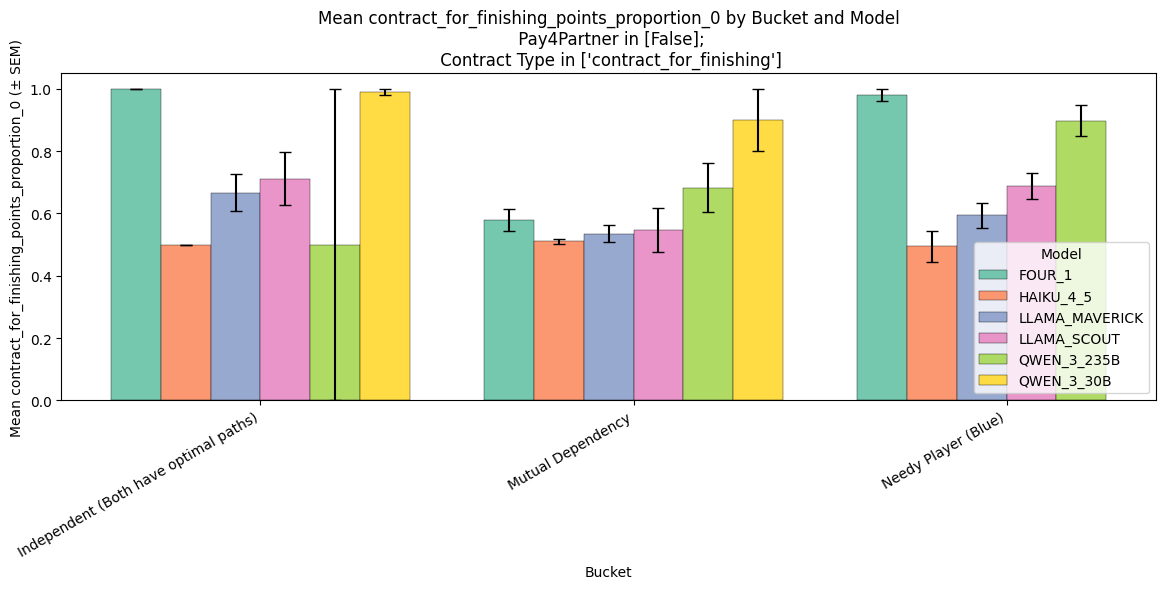

In [135]:
grouped = plot_mean_metric_bar(
    df,
    metric="contract_for_finishing_points_proportion_0",
    x="Bucket",
    hue="Model",
    filters=[("Pay4Partner", [False]), 
              ('Contract Type', ['contract_for_finishing']),
                ],
    ylim=None
)

In [79]:
df[df['Model']== 'LLAMA_SCOUT']['Accuracy'].mean()

np.float64(0.8440848214285716)